### TP 2 VISIÓN POR COMPUTADORA.

Integrantes: 
- Fernando Vasconcelos
- Lara Rosenberg
- Victoria Terán

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib
import pandas as pd


In [2]:
# Ruta del video
video_path = 'focus_video.mov'

Definimos las funciones necesarias

In [3]:
def calcular_iqm(image):
    # Paso 1: Calcular la transformada de Fourier
    F = np.fft.fft2(image)
    
    # Paso 2: Llevar la baja frecuencia al origen
    FC = np.fft.fftshift(F)
    
    # Paso 3: Calcular el módulo de la transformada
    AF = np.abs(FC)
    
    # Paso 4: Calcular el umbral (puedes ajustar este valor)
    umbral = np.max(AF) / 1000
    
    # Paso 5: Contar los píxeles que superan el umbral
    supera_tresh = np.sum(AF > umbral)
    
    # Medida de calidad de imagen
    M, N = image.shape
    iqm = supera_tresh / (M * N)
    return iqm

In [4]:
def calcular_acm(image): 
    mean = np.mean(image)  
    histogram, _ = np.histogram(image, bins=256, range=(0, 256))  
    histogram = histogram / histogram.sum()  
    acm = np.sum(np.abs(np.arange(256) - mean) * histogram)  
    return acm  

In [5]:
def calcular_sta3(image, block_size=50):
    # Aplicar el filtro Laplaciano para resaltar los bordes
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    # Dividir la imagen en bloques
    height, width = image.shape
    focus_measure = 0
    for i in range(0, height - block_size, block_size):
        for j in range(0, width - block_size, block_size):
            # Extraer el bloque
            block = laplacian[i:i + block_size, j:j + block_size]
            
            # Calcular la varianza del bloque
            variance = np.var(block)
            sta3 += variance
    return sta3


EXPERIMENTO 1

In [4]:
matplotlib.use('Agg') 
def convert_to_img(value_list: list, image_shape: tuple, total_frames: int):
    
    fig, ax = plt.subplots(figsize=(image_shape[0]/100, image_shape[1]/100))
    ax.set_xlim(0, total_frames+total_frames*0.1)
    ax.scatter(range(len(value_list)),value_list)
    ax.set_xlabel('Número de Frame',labelpad =1)
    ax.set_ylabel('IQM')
    ax.set_title('Evolución IQM por Frame', fontsize=10)
    ax.grid(True) 

    # Convertir el gráfico en un array
    canvas = FigureCanvas(fig)
    canvas.draw()
    plt.close(fig)
    width, height = canvas.get_width_height()
    # Convertir a un array de NumPy 
    image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8').reshape((height, width, 4))
    
    # Remove alplha channel and return
    return image[:,:,:3]
    

captura_video = cv2.VideoCapture(video_path)

fm_score_list = []
frame_numeros = []

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(captura_video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    delay = int(600 / fps)
    

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break
    
        # Obtenemos la medicion    
        fm =  calcular_iqm(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        fm_score_list.append(fm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        
        # Combina el frame original y la grafica de la medicion del blur
        img_frame = convert_to_img(fm_score_list, (frame_width, frame_height), total_frames)
        frame_combined = np.hstack((frame, img_frame ))
        # Mostrar el frame combinado
        cv2.imshow('Video', frame_combined)

        if fm >= max(fm_score_list):
            max_iqm_frame= int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))
        

        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break

    print('Frame de maximo IQM', max_iqm_frame)
    print('Valor IQM',  max(fm_score_list))

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv2.waitKey(0)
cv2.destroyAllWindows()

%matplotlib inline

Frame de maximo IQM 110
Valor IQM 0.028624131944444443


Frame de maximo IQM 110


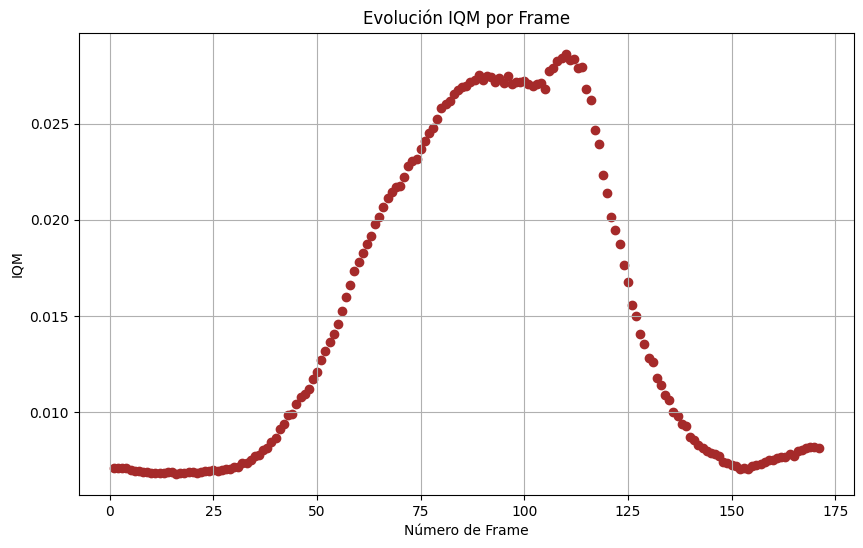

Frame de maximo ACM 118


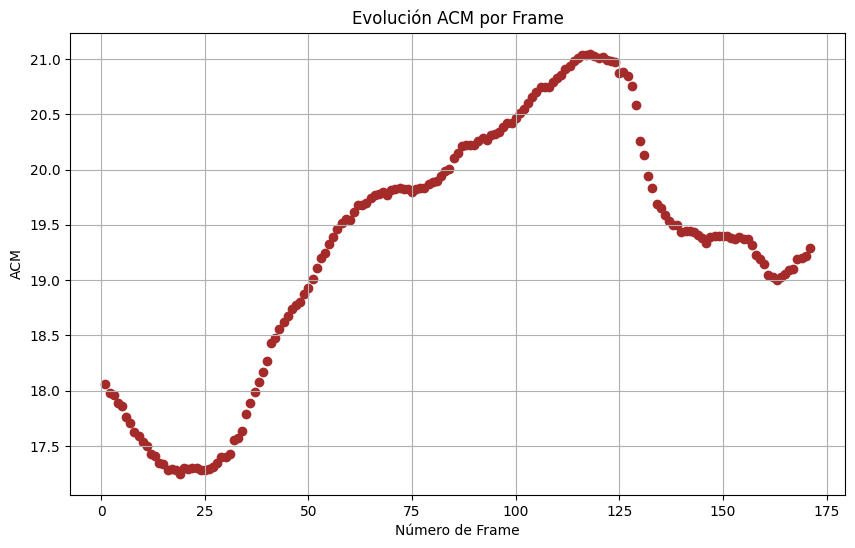

In [10]:
def procesar_video_completo(video_path, metric = calcular_iqm, name_metric = 'IQM'):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []
    
    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if iqm >= max(iqm_lista):
            max_iqm_frame= int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))
            
    print(f'Frame de maximo {name_metric} {max_iqm_frame} ({max(iqm_lista)})' )
    captura_video.release()
    
    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_lista, color='brown', marker='o')
    
    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric}')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()

procesar_video_completo(video_path,metric=calcular_iqm, name_metric = 'IQM')
procesar_video_completo(video_path,metric=calcular_acm, name_metric = 'ACM')

EXPERIMENTO 2

Frame de maximo IQM 112 (0.4635339330945934)


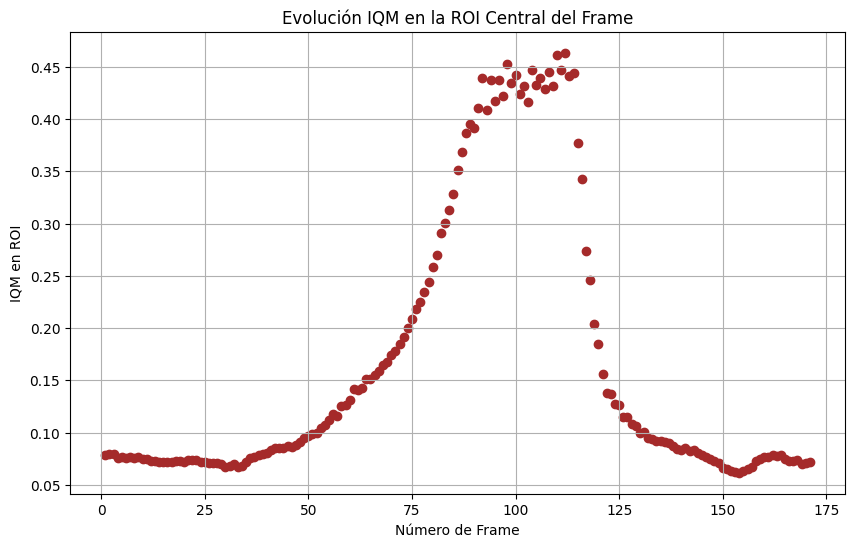

In [5]:
def procesar_video_roi(video_path, porc_roi=0.05,metric = calcular_iqm, name_metric = 'IQM'):
    captura_video = cv2.VideoCapture(video_path)
    metric_list = []
    frame_numeros = []
    
    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return


    # Primer bucle para calcular los IQM y el máximo IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        # Obtener dimensiones del frame  
        height, width = frame.shape[:2]  
    
        # Calcular el área total del frame  
        area_total = height * width  
    
        # Calcular el área de la ROI en base al porcentaje  
        area_roi = area_total * porc_roi  
    
        # Determinar la longitud y ancho de la ROI  
        roi_side = int((area_roi) ** 0.5)  # Lado de la ROI cuadrada (para simplicidad)  
    
        # Asegurarse de que la ROI no exceda los límites del frame  
        roi_side = min(roi_side, height, width)  
    
        # Calcular las coordenadas de la ROI centrada  
        start_x = (width - roi_side) // 2  
        start_y = (height - roi_side) // 2  
    
        # Definir la ROI  
        roi = frame[start_y:start_y + roi_side, start_x:start_x + roi_side]  

        # Convertir la ROI a escala de grises
        roi_gris = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        
        # Calcular IQM para la ROI
        value_metric = metric(roi_gris)
        metric_list.append(value_metric)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if value_metric >= max(metric_list):
            max_metric_frame= int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

            
    print(f'Frame de maximo {name_metric} {max_metric_frame} ({max(metric_list)})' )

    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)  

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():  
        print("Error al abrir el video.")  
        exit()  

    frame_number = 0  
    while True:  
        ret, frame = captura_video.read()  
        if not ret:  
            break  
        
        frame_number += 1  
        
        # Verificamos si el número de frames coincide con el fotograma de la métrica máxima  
        if frame_number == max_metric_frame:   
            cv2.rectangle(frame,(start_x, start_y), (start_x + roi_side, start_y + roi_side), (0, 255, 0), 2)  # Marco con verde el frame con métrica máxima  
        else:  
            cv2.rectangle(frame, (start_x, start_y), (start_x + roi_side, start_y + roi_side), (0, 0, 255), 2)  # Marco con rojo el resto de los frames  

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video con ROI', frame)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break 
    # Liberar recursos  
    captura_video.release()  
    cv2.destroyAllWindows()  

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, metric_list, color='brown', marker='o')
    
    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} en ROI')
    plt.title(f'Evolución {name_metric} en la ROI Central del Frame')
    plt.grid(True)
    plt.show()


procesar_video_roi(video_path, porc_roi=0.05,metric = calcular_iqm, name_metric = 'IQM')
#procesar_video_roi(video_path, porc_roi=0.05,metric = calcular_acm, name_metric = 'ACM')

EXPERIMENTO 3

Frame de maximo IQM 114 (0.9866666666666668)


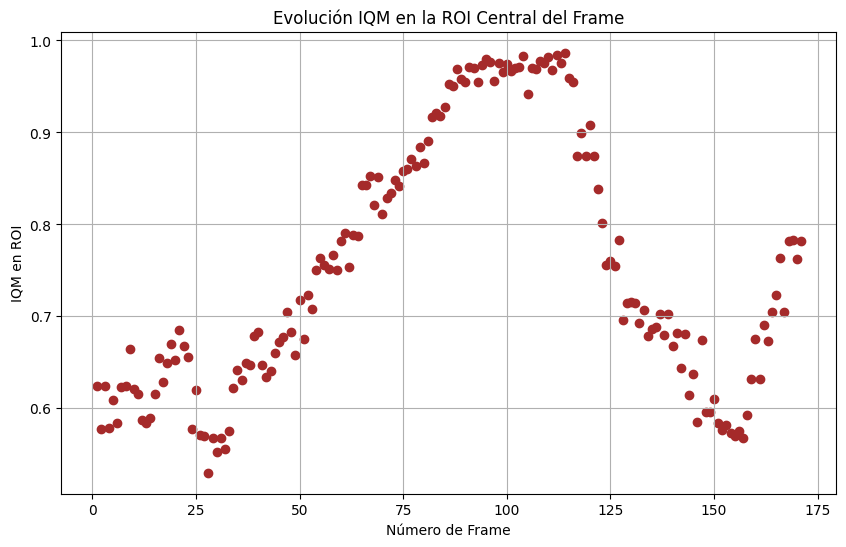

In [37]:
def procesar_video_focus_matrix(video_path,  margin=10, range_X=3, range_Y=3, metric = calcular_iqm, name_metric = 'IQM'):
    captura_video = cv2.VideoCapture(video_path)

    metric_frame =[]
    frame_numeros = []
    

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return


    # Primer bucle para calcular los IQM y el máximo IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        height, width = frame.shape[:2] 

        total_width = range_X * margin + (range_X - 1) * margin  
        total_height = range_Y * margin + (range_Y - 1) * margin  

        if total_width > width or total_height > height:  
            print("El margen es demasiado grande para el tamaño del frame.")  
            return [], frame  # Devolver la imagen sin modificaciones  

        start_x = (width - total_width) // 2  
        start_y = (height - total_height) // 2  

        rois = []  # Lista para almacenar los ROIs  

        for i in range(range_Y):  
            for j in range(range_X):  
                start_point = (start_x + j * (margin *2),  
                            start_y + i * (margin *2))  

                end_point = (start_point[0] + margin,  
                            start_point[1] + margin)  

                roi = frame[start_point[1]:end_point[1], start_point[0]:end_point[0]]  
                rois.append((roi, (start_point, end_point))) 

        # Convertir la ROI a escala de grises
        roi_gris = [cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) for roi,_ in rois]
        value_metric = [metric(roi).item() for roi  in roi_gris]  
        mean_metric =  np.mean(value_metric).item()

        metric_frame.append(mean_metric) 
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))

    df_metric_values= pd.DataFrame({'frame':frame_numeros,'metric':metric_frame})
    max_metric_frame= df_metric_values[df_metric_values.metric == df_metric_values.metric.max().item()]['frame'].item()
    max_metric_value= df_metric_values[df_metric_values.metric == df_metric_values.metric.max().item()]['metric'].item()

           
    print(f'Frame de maximo {name_metric} {max_metric_frame} ({max_metric_value})' )



    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)  

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():  
        print("Error al abrir el video.")  
        exit()  

    frame_number = 0  
    while True:  
        ret, frame = captura_video.read()  
        if not ret:  
            break  
        
        frame_number += 1  

        for roi, (start_point, end_point) in rois:  
            if frame_number == max_metric_frame:  
                cv2.rectangle(frame, start_point, end_point,  (0, 255, 0) , 2) 
            else:  
                cv2.rectangle(frame, start_point, end_point,  (0, 0, 255) , 2) 

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video con ROI', frame)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break 

    # Liberar recursos  
    captura_video.release()  
    cv2.destroyAllWindows()  

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, metric_frame, color='brown', marker='o')
    
    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} en ROI')
    plt.title(f'Evolución {name_metric} en la ROI Central del Frame')
    plt.grid(True)
    plt.show()


procesar_video_focus_matrix(video_path,  margin=10, range_X=3, range_Y=3, metric = calcular_iqm, name_metric = 'IQM')

Frame de maximo ACM 114 (9.364331428571429)


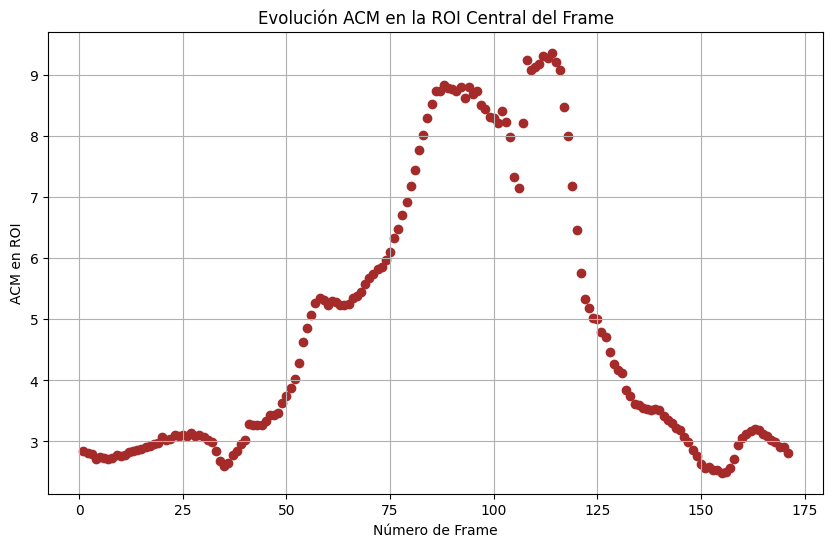

In [41]:
procesar_video_focus_matrix(video_path,  margin=10, range_X=7, range_Y=5, metric = calcular_acm , name_metric = 'ACM')

### BONUS

UNSHARP MASKING --> algoritmo que tiende a enfocar o mejorar los bordes a traves de un filtro suavizado.
Pasos:
1. Aplicamos un filtro gaussiano para desenfocar
2. Restamos la imagen original con la suavizada para que sobrevivan los componentes de alta frecuencia
3. Agregamos la mascara a la imagen original.

In [6]:
def unsharp_masking(image_gray, sigma=1.0, strength=1.5):
    
    # Aplicar un filtro Gaussiano para obtener la imagen desenfocada
    blurred = cv2.GaussianBlur(image_gray, (0, 0), sigma)
    
    # Calcular la imagen de la máscara de enfoque (imagen original - imagen desenfocada)
    sharpened = cv2.addWeighted(image_gray, 1.0 + strength, blurred, -strength, 0)
    
    # Asegurarse de que los valores estén en el rango de 0 a 255
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened


Frame de maximo IQM 112 (0.04810329861111111)


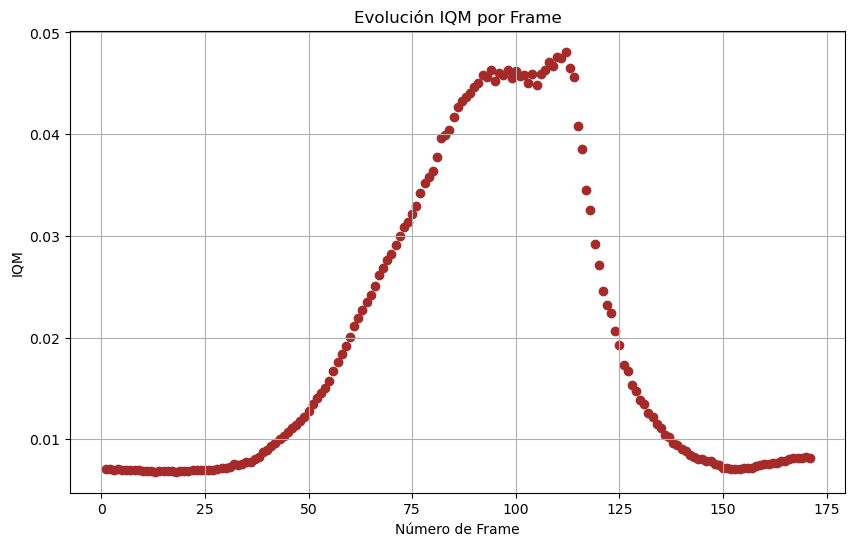

In [7]:
def procesar_video_completo(video_path, metric = calcular_iqm, name_metric = 'IQM', activate_um = False, sigma_um=1.0, strenght_um=1.5):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []
    
    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        if activate_um == True:
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_gris = unsharp_masking(frame_gris, sigma = sigma_um, strength=strenght_um)
        else:
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if iqm >= max(iqm_lista):
            max_iqm_frame= int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))
            
    print(f'Frame de maximo {name_metric} {max_iqm_frame} ({max(iqm_lista)})' )
    captura_video.release()
    
    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_lista, color='brown', marker='o')
    
    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric}')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()

procesar_video_completo(video_path,metric=calcular_iqm, name_metric = 'IQM', activate_um = True, sigma_um=1.0, strenght_um=1.5)

Frame de maximo IQM 92 (0.3606727430555556)


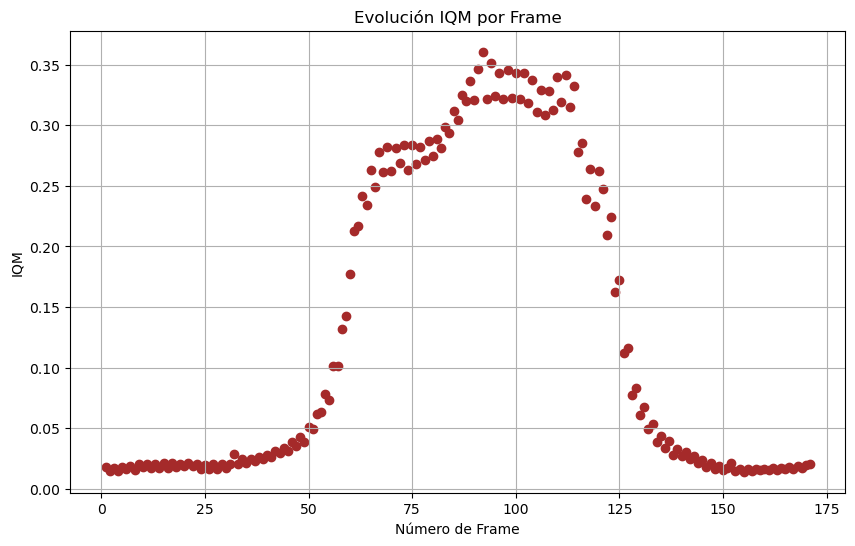

In [8]:
procesar_video_completo(video_path,metric=calcular_iqm, name_metric = 'IQM', activate_um = True, sigma_um=1.0, strenght_um=20)

Frame de maximo IQM 92 (0.7360468163158355)


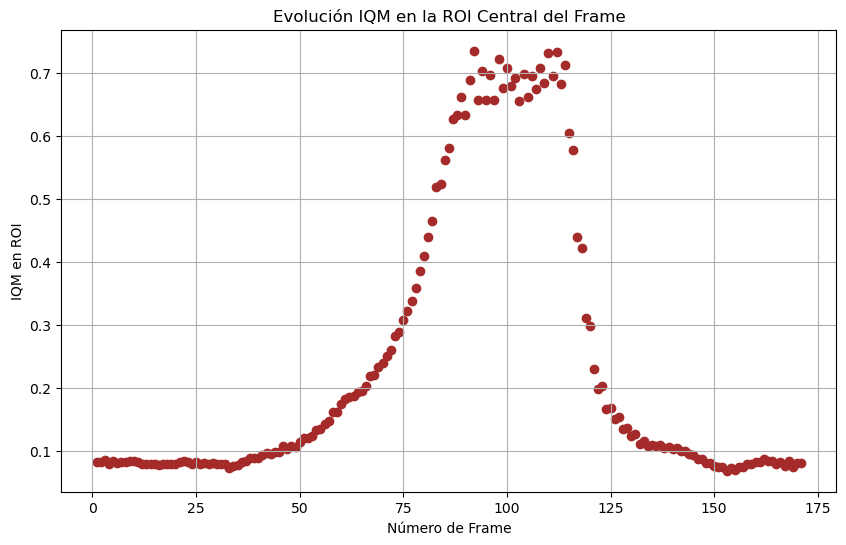

In [9]:
def procesar_video_roi(video_path, porc_roi=0.05,metric = calcular_iqm, name_metric = 'IQM', activate_um = False, sigma_um=1.0, strenght_um=1.5):
    captura_video = cv2.VideoCapture(video_path)
    metric_list = []
    frame_numeros = []
    
    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return


    # Primer bucle para calcular los IQM y el máximo IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        # Obtener dimensiones del frame  
        height, width = frame.shape[:2]  
    
        # Calcular el área total del frame  
        area_total = height * width  
    
        # Calcular el área de la ROI en base al porcentaje  
        area_roi = area_total * porc_roi  
    
        # Determinar la longitud y ancho de la ROI  
        roi_side = int((area_roi) ** 0.5)  # Lado de la ROI cuadrada (para simplicidad)  
    
        # Asegurarse de que la ROI no exceda los límites del frame  
        roi_side = min(roi_side, height, width)  
    
        # Calcular las coordenadas de la ROI centrada  
        start_x = (width - roi_side) // 2  
        start_y = (height - roi_side) // 2  
    
        # Definir la ROI  
        roi = frame[start_y:start_y + roi_side, start_x:start_x + roi_side]  

        # Convertir la ROI en gris
        if activate_um == True:
            roi_gris = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            roi_gris = unsharp_masking(roi_gris, sigma = sigma_um, strength=strenght_um)
        else:
            roi_gris = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        
        # Calcular IQM para la ROI
        value_metric = metric(roi_gris)
        metric_list.append(value_metric)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if value_metric >= max(metric_list):
            max_metric_frame= int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

            
    print(f'Frame de maximo {name_metric} {max_metric_frame} ({max(metric_list)})' )

    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)  

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():  
        print("Error al abrir el video.")  
        exit()  

    frame_number = 0  
    while True:  
        ret, frame = captura_video.read()  
        if not ret:  
            break  
        
        frame_number += 1  
        
        # Verificamos si el número de frames coincide con el fotograma de la métrica máxima  
        if frame_number == max_metric_frame:   
            cv2.rectangle(frame,(start_x, start_y), (start_x + roi_side, start_y + roi_side), (0, 255, 0), 2)  # Marco con verde el frame con métrica máxima  
        else:  
            cv2.rectangle(frame, (start_x, start_y), (start_x + roi_side, start_y + roi_side), (0, 0, 255), 2)  # Marco con rojo el resto de los frames  

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video con ROI', frame)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break 
    # Liberar recursos  
    captura_video.release()  
    cv2.destroyAllWindows()  

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, metric_list, color='brown', marker='o')
    
    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} en ROI')
    plt.title(f'Evolución {name_metric} en la ROI Central del Frame')
    plt.grid(True)
    plt.show()


procesar_video_roi(video_path, porc_roi=0.05,metric = calcular_iqm, name_metric = 'IQM', activate_um = True, sigma_um=1.0, strenght_um=1.5)

Frame de maximo IQM 92 (0.9835793519084636)


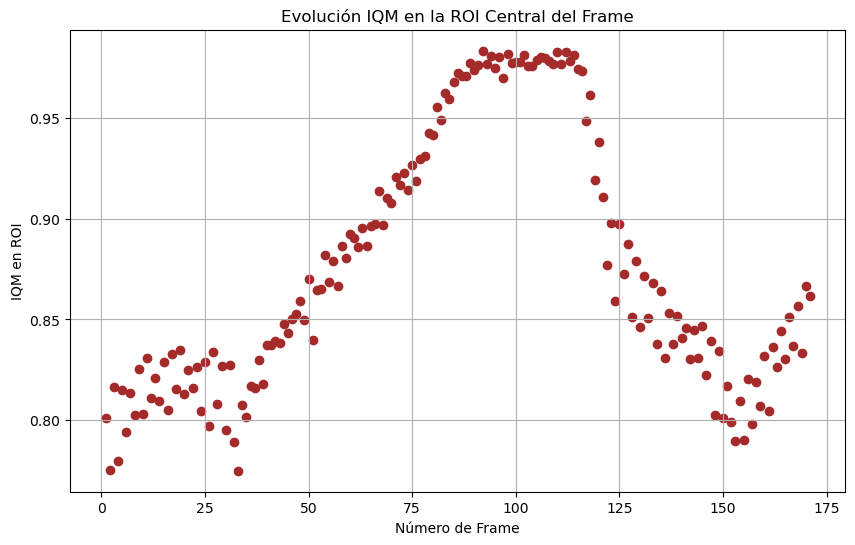

In [10]:
procesar_video_roi(video_path, porc_roi=0.05,metric = calcular_iqm, name_metric = 'IQM', activate_um = True, sigma_um=1.0, strenght_um=20)

Frame de maximo IQM [92, 111] ([0.9988888888888889, 0.9988888888888889])


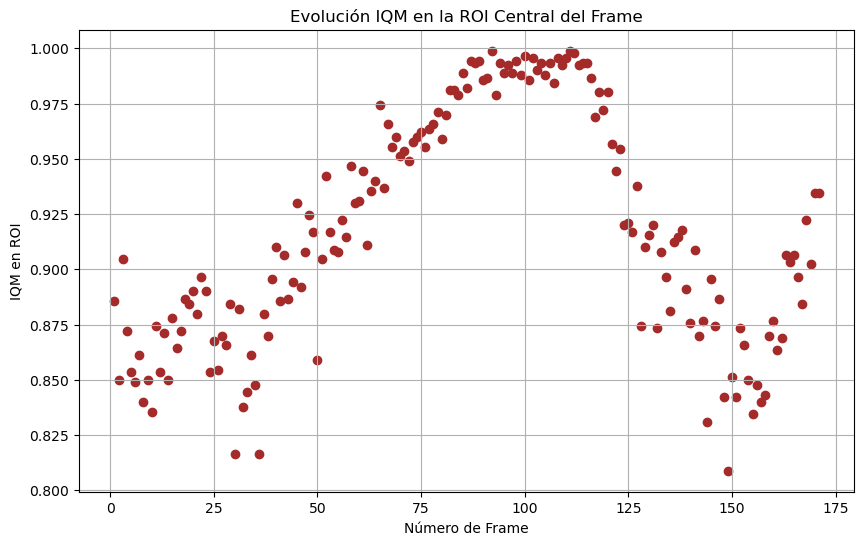

In [7]:
def procesar_video_focus_matrix(video_path,  margin=10, range_X=3, range_Y=3, metric = calcular_iqm, name_metric = 'IQM', activate_um = True, sigma_um=1.0, strenght_um=20):
    captura_video = cv2.VideoCapture(video_path)

    metric_frame =[]
    frame_numeros = []
    

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return


    # Primer bucle para calcular los IQM y el máximo IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        height, width = frame.shape[:2] 

        total_width = range_X * margin + (range_X - 1) * margin  
        total_height = range_Y * margin + (range_Y - 1) * margin  

        if total_width > width or total_height > height:  
            print("El margen es demasiado grande para el tamaño del frame.")  
            return [], frame  # Devolver la imagen sin modificaciones  

        start_x = (width - total_width) // 2  
        start_y = (height - total_height) // 2  

        rois = []  # Lista para almacenar los ROIs  

        # Convertir el frame a escala de grises
        if activate_um == True:
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_gris = unsharp_masking(frame_gris, sigma = sigma_um, strength=strenght_um)
        else: 
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


        for i in range(range_Y):  
            for j in range(range_X):  
                start_point = (start_x + j * (margin *2),  
                            start_y + i * (margin *2))  

                end_point = (start_point[0] + margin,  
                            start_point[1] + margin)  

                roi = frame_gris[start_point[1]:end_point[1], start_point[0]:end_point[0]]  
                rois.append((roi, (start_point, end_point))) 
                
        roi_gris = [roi for roi,_ in rois]
        value_metric = [metric(roi).item() for roi in roi_gris]  
        mean_metric =  np.mean(value_metric).item()

        metric_frame.append(mean_metric) 
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))

    df_metric_values= pd.DataFrame({'frame':frame_numeros,'metric':metric_frame})
    max_metric_frame= df_metric_values[df_metric_values.metric == df_metric_values.metric.max()]['frame']
    max_metric_value= df_metric_values[df_metric_values.metric == df_metric_values.metric.max()]['metric']

           
    print(f'Frame de maximo {name_metric} {list(max_metric_frame)} ({list(max_metric_value)})' )

    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)  

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():  
        print("Error al abrir el video.")  
        exit()  

    frame_number = 0  
    while True:  
        ret, frame = captura_video.read()  
        if not ret:  
            break  
        
        frame_number += 1  

        for roi, (start_point, end_point) in rois:  
            if frame_number in list(max_metric_frame):  
                cv2.rectangle(frame, start_point, end_point,  (0, 255, 0) , 2) 
            else:  
                cv2.rectangle(frame, start_point, end_point,  (0, 0, 255) , 2) 

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video con ROI', frame)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break 

    # Liberar recursos  
    captura_video.release()  
    cv2.destroyAllWindows()  

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, metric_frame, color='brown', marker='o')
    
    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} en ROI')
    plt.title(f'Evolución {name_metric} en la ROI Central del Frame')
    plt.grid(True)
    plt.show()


procesar_video_focus_matrix(video_path,  margin=10, range_X=3, range_Y=3, metric = calcular_iqm, name_metric = 'IQM',activate_um = True, sigma_um=1.0, strenght_um=1.5)